# Car Selling Platform Test
Using Gradio, LangChain and _Zapier

Mounting Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive




Classification Report & Confusion Matrix of the best model without resampling the data

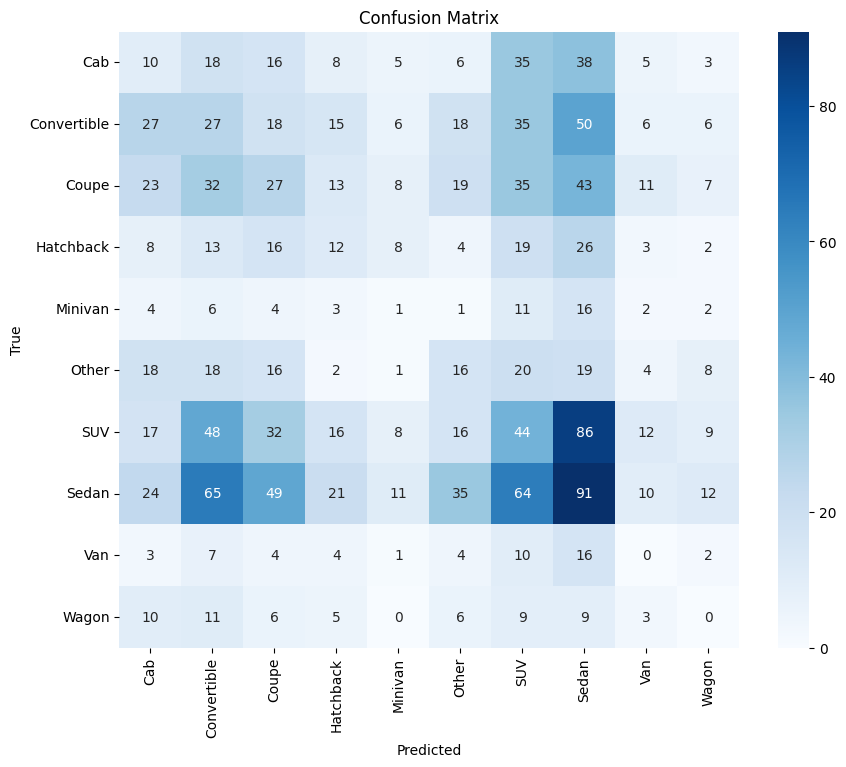

              precision    recall  f1-score   support

         Cab       0.07      0.07      0.07       144
    Convertible    0.11     0.13       0.12       208
       Coupe       0.14      0.12      0.13       218
    Hatchback       0.12      0.11      0.11       111
     Minivan       0.02      0.02      0.02        50
       Other       0.13      0.13      0.13       122
         SUV       0.16      0.15      0.15       288
       Sedan       0.23      0.24      0.23       382
         Van       0.00      0.00      0.00        51
       Wagon       0.00      0.00      0.00        59

    accuracy                           0.14      1633
    macro avg       0.10      0.10      0.10      1633
    weighted avg    0.14      0.14      0.14      1633

In [ ]:
from sklearn.metrics import classification_report

# Generate classification report
# class_report = classification_report(val_true_labels, val_pred_labels, target_names=class_labels)

# Print the classification report
# print(class_report)


              precision    recall  f1-score   support

         Cab       0.07      0.07      0.07       144
 Convertible       0.11      0.13      0.12       208
       Coupe       0.14      0.12      0.13       218
   Hatchback       0.12      0.11      0.11       111
     Minivan       0.02      0.02      0.02        50
       Other       0.13      0.13      0.13       122
         SUV       0.16      0.15      0.15       288
       Sedan       0.23      0.24      0.23       382
         Van       0.00      0.00      0.00        51
       Wagon       0.00      0.00      0.00        59

    accuracy                           0.14      1633
   macro avg       0.10      0.10      0.10      1633
weighted avg       0.14      0.14      0.14      1633



## LLM Model

In [3]:
!pip install langchain

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.1/46.1 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 6.7 MB/s eta 0:00:00


In [4]:
!pip install openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.3/220.3 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
llmx 0.0.15a0 requires cohere, which is not installed.
llmx 0.0.15a0 requires tiktoken, which is not installed.


In [15]:
import json

# Load API key, base, version, type and engine from configuration file
with open("config_file.json", "r") as config_file:
    config = json.load(config_file)
    api_key = config["OPENAI_API_KEY"]
    api_version = config["OPENAI_API_VERSION"]
    api_base = config["OPENAI_API_BASE"]
    api_type = config["OPENAI_API_TYPE"]
    engine = config["engine"]



In [18]:
!pip install Kor

In [27]:
!pip install markdownify

In [29]:
# Kor!
from kor.extraction import create_extraction_chain
from kor.nodes import Object, Text, Number

# LangChain Models
from langchain.chat_models import ChatOpenAI
from langchain.llms import OpenAI

# Standard Helpers
import pandas as pd
import requests
import time
import json
from datetime import datetime

# Text Helpers
from bs4 import BeautifulSoup
from markdownify import markdownify as md

# For token counting
from langchain.callbacks import get_openai_callback

def printOutput(output):
    print(json.dumps(output,sort_keys=True, indent=3))

In [21]:
llm = ChatOpenAI(
    model_name="gpt-3.5-turbo",
    temperature=0,
    # max_tokens=500,
    openai_api_key=api_key
)

In [22]:
tires = Object(
    id="tires",
    description="The tires of the car",
    attributes=[
        Text(id="type", description="the type of the car tires"),
        Number(id="manufactured_year", description="The year the car tires were manufactured"),

    ],
    examples=[
        (
            "Equipped with brand-new all-season tires manufactured in 2022.",
            [
                {
                  "type": "brand-new",
                  "manufactured_year": 2022
                }
            ],
        )
    ]
)

In [23]:
notices = Object(
    id="notices",
    description="Any notice about replaced or changed car parts due to accidents or collision",
    attributes=[
        Text(id="type", description="The cause for the notice or parts replacement"),
        Text(id="description", description="The cause and replacement details"),

    ],
    examples=[
        (
            "Notably, the rear bumper has been replaced after a minor collision. ",
            [
                {
                  "type": "collision",
                  "description": "The rear bumper has been replaced after a minor collision."
                }
            ],
        )
    ]
)

In [24]:
price = Object(
    id="estimated_price",
    description="The price of the car",
    attributes=[
        Number(id="amount", description="The amount of the car price"),
        Text(id="currency", description="The currency of the car price"),

    ],
    examples=[
        (
            "Priced at 1 million L.E.",
            [
                {
                  "amount": 1000000,
                  "currency": "L.E"
                }
            ],
        )
    ]
)

In [25]:
cars_schema = Object(
    id="car",
    description="Descriptive information about a car",
    examples=[
        (
            "Blue Ford Fusion produced in 2015 featuring a 2.0-liter engine. The vehicle has low mileage with only 40,000 miles on the odometer. Equipped with brand-new all-season tires manufactured in 2022. The car's windows are tinted for added privacy. Notably, the rear bumper has been replaced after a minor collision. Priced at 1 million L.E.",
            [
                {
                    "body_type":"sedan",
                    "color": "Blue",
                    "brand": "Ford",
                    "model": "Fusion",
                    "manufactured_year": 2015,
                    "motor_size_cc": 2000,
                    "tires": {
                    "type": "brand-new",
                    "manufactured_year": 2022
                    },
                    "windows": "tinted",
                    "notices": [
                      {
                        "type": "collision",
                        "description": "The rear bumper has been replaced after a minor collision."
                      }
                    ],
                    "price": {
                      "amount": 1000000,
                      "currency": "L.E"
                    }
                  }
            ],
        )
    ],
    attributes=[
        Text(
            id="body_type",
            description="The type of the car"
        ),
        Text(
            id="color",
            description="The color of the car"
        ),
        Text(
            id="brand",
            description="The make or brand of the car"
        ),
        Text(
            id="model",
            description="The model of the car"
        ),
        Number(
            id="manufactured_year",
            description="The year the car was manufactured"
        ),
        Number(
            id="motor_size_cc",
            description="The motor size of the car in cc(s)"
        ),
        tires,
        Text(
            id="windows",
            description="The make or brand of the car"
        ),
        notices,
        price
    ]
)

In [31]:
chain = create_extraction_chain(llm, cars_schema, encoder_or_encoder_class="json")

In [32]:
text = """
White Daewoo Juliet manufactured at 2001 with a motor size of 1500 cc and the four tires are used they are from 2020. The windows are electrical. There is a small notice the wind shield has been changed due to a small accident. Estimated price is 220K L.E.
"""
output = chain.predict_and_parse(text=(text))["data"]

printOutput(output)

/usr/local/lib/python3.10/dist-packages/langchain/chains/llm.py:321: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(


AuthenticationError: ignored

In [ ]:
json_response = json.loads(output)

In [ ]:
body_type = json_response["body_type"]
color = json_response["color"]
brand = json_response["brand"]
model = json_response["model"]
manufactured_year = json_response["manufactured_year"]
motor_size_cc = json_response["motor_size_cc"]
tires = json_response["tires"]
windows = json_response["windows"]
notices = json_response["notices"]
estimated_price = json_response["estimated_price"]

## Gradio UI

In [ ]:
!pip install gradio

In [ ]:
import gradio as gr
from tensorflow.keras.models import load_model
import joblib
import numpy as np

In [ ]:
# Load the trained model
model = load_model('VGG19_best_car_classification_model.h5')



In [ ]:
def predict_class(image,description):
    # Preprocess the image
    image_array = np.array(image) / 255.0  # Normalize the image
    image_array = np.expand_dims(image_array, axis=0)  # Add batch dimension

    # Make predictions
    predicted_car_type = model.predict(image_array)
    output = chain.predict_and_parse(text=(description))["data"]

    return predicted_car_type,output
    #return predicted_class[0]

In [ ]:
iface = gr.Interface(
    fn=predict_class,
    inputs=[gr.Image(type="pil", label="Upload Image"), gr.Textbox(lines=4, label="Car Description")],
    outputs=gr.Label(),
    live=True,
    interpretation="default"
)

iface.launch()

## Use LangChain to send G-mails

In [ ]:
final_json = {
    "car_type": predicted_car_type
    "color": color,
    "brand": brand,
    "model": model,
    "manufactured_year": manufactured_year,
    "motor_size_cc": motor_size_cc,
    "tires": tires,
    "windows": windows,
    "notices": notices,
    "estimated_price": estimated_price,
}

In [ ]:
from langchain.llms import OpenAI
from langchain.agents import initialize_agent
from langchain.agents.agent_toolkits import ZapierToolkit
from langchain.utilities.zapier import ZapierNLAWrapper
import os

In [ ]:
import json

# Load API key from configuration file
with open("config.json", "r") as config_file:
    config = json.load(config_file)
    # sender = config["SenderEmail"]              # I don't need them since I got a Zapier API
    # senderpass = config["SenderPassword"]
    recepient = config["RecepientEmail"]
    zapier_api_key = config["ZapierApiKey"]

In [ ]:
llm = OpenAI(temperature=0)
zapier = ZapierNLAWrapper()
toolkit = ZapierToolkit.from_zapier_nla_wrapper(zapier)
agent = initialize_agent(toolkit.get_tools(), llm, agent="zero-shot-react-description", verbose=True)

In [ ]:
for tool in toolkit.get_tools():         # To learn more about the Gmail: Send E-mail tool
    print (tool.name)
    print (tool.description)
    print ("\n\n")

In [ ]:
agent.run("Send Email to {recepient} that contains the car image {image} and the {final_json} with the subject: Car Properties", recepient, image, final_json)